In [37]:
import sympy as sp
import numpy as np
from dataclasses import dataclass
from typing import List
from sympy.plotting import plot3d
import matplotlib.pyplot as plt

# State.py

In [38]:
# STATE CLASS
# Represents a specific configuration (coordinates)
@dataclass(frozen=True)
class State:
    x: float
    y: float

    def __add__(self, other):
        # Helper for vector addition (used for velocity/movement)
        if isinstance(other, np.ndarray) or isinstance(other, list):
            return State(self.x + other[0], self.y + other[1])
        return NotImplemented

In [39]:
# ==========================================
# NODE CLASS
# Wraps a State with bookkeeping info (value, gradient)
# ==========================================
@dataclass
class Node:
    state: State
    value: float
    gradient: np.ndarray

# Problem.py

In [40]:
# PROBLEM CLASS
# Defines the environment, the math, and the goal using SymPy
class Problem:
    def __init__(self):
        # Define Symbolic Variables
        self.sym_x, self.sym_y = sp.symbols('x y')

        # Define Symbolic Function
        self.sym_f = (sp.sin(self.sym_x/4) + sp.cos(self.sym_y/4)
                       - sp.sin((self.sym_x*self.sym_y)/16)
                       + sp.cos(self.sym_x**2/16) + sp.sin(self.sym_y**2/16))

        # Define Symbolic Gradient
        self.grad_expr = [sp.diff(self.sym_f, v) for v in (self.sym_x, self.sym_y)]

        # Compile to numpy functions for fast numerical evaluation by the agent
        self.f_num = sp.lambdify((self.sym_x, self.sym_y), self.sym_f, 'numpy')
        self.grad_num = sp.lambdify((self.sym_x, self.sym_y), self.grad_expr, 'numpy')

    def evaluate(self, state: State) -> Node:
        """Creates a Node with calculated value and gradient for a given State."""
        val = self.f_num(state.x, state.y)
        grad = np.array(self.grad_num(state.x, state.y))
        return Node(state, val, grad)

# Agent.py

In [41]:
# HILL CLIMBING AGENT CLASS
# The Hill Climber strategy
class HillClimbingAgent:
    def __init__(self, step_size=0.5, noise=0.05, max_iter=500, momentum=0.8):
        self.step_size = step_size
        self.noise = noise
        self.max_iter = max_iter
        self.momentum = momentum
        self.path: List[Node] = []

    def solve(self, problem: Problem, start_state: State) -> Node:
        current_node = problem.evaluate(start_state)
        self.path = [current_node]

        velocity = np.zeros(2)
        step = self.step_size

        for _ in range(self.max_iter):
            grad = current_node.gradient
            norm = np.linalg.norm(grad)

            if norm < 1e-4:  # Convergence check
                break

            # Normalize gradient
            direction = grad / (norm + 1e-10)

            # Apply Momentum
            velocity = self.momentum * velocity + step * direction

            # Calculate new position with noise
            noise_vec = np.random.normal(0, self.noise, 2)
            move_vec = velocity + noise_vec

            # Create candidate state
            new_state = current_node.state + move_vec
            neighbor_node = problem.evaluate(new_state)

            # Hill Climbing Acceptance Logic
            if neighbor_node.value > current_node.value:
                current_node = neighbor_node
                self.path.append(current_node)
                step = min(step * 1.05, 1.0)  # Accelerate
            else:
                step *= 0.5  # Decelerate
                if step < 1e-4:
                    break

        return current_node

# Visualizer.py

In [42]:
# VISUALIZER CLASS
# Handles 3D plotting with path overlay
class Visualizer:
    @staticmethod
    def plot(problem, points_data, title_suffix=""):
        unzipped_path = zip(*points_data)
        xs, ys, zs = map(list, unzipped_path)

        p = plot3d(problem.sym_f, (problem.sym_y, -10, 10), (problem.sym_x, -10, 10),
                   title=f"3D visual {title_suffix}", show=False)
        p._backend.process_series()
        p._backend.ax.set_zlim(-4, 4)

        # Set custom tick marks with step 2.5
        ticks = [-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10]
        p._backend.ax.set_xticks(ticks)
        p._backend.ax.set_yticks(ticks)

        # Plot the path
        p._backend.ax.plot(xs, ys, zs, color='red', linewidth=2)

        # Show only this plot
        plt.show()

        return p

# Main.py

This visualization shows:
- **3D Surface**: The objective function landscape we're trying to optimize
- **Red Path**: The trajectory of visited points during the hill climbing search
  - Starting point begins at coordinates (0, 0)
  - Each point represents a state evaluated by the agent
  - The path shows how the algorithm climbs toward higher values (local/global maxima)
  - Line segments connect consecutive states to illustrate the search progression

Best solution found:
   Location: (2.8959, -4.7290)
   Value: 3.6472
Generating 3D plot with Hill Climbing path...


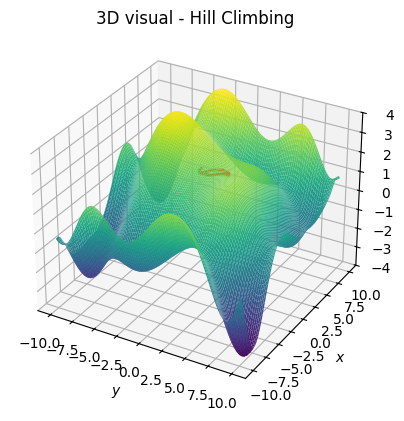

In [43]:
# ==========================================
# MAIN EXECUTION & VISUALIZATION
# ==========================================

if __name__ == "__main__":
    # 1. Setup Problem & Agent
    problem = Problem()
    agent = HillClimbingAgent(step_size=0.5, momentum=0.8)
    start_state = State(0, 0)

    # 2. Run Optimization
    best_node = agent.solve(problem, start_state)

    print("Best solution found:")
    print(f"   Location: ({best_node.state.x:.4f}, {best_node.state.y:.4f})")
    print(f"   Value: {best_node.value:.4f}")

    # 3. Visualization using Visualizer class
    print("Generating 3D plot with Hill Climbing path...")

    # Prepare points data: list of (x, y, z) tuples
    points_data = [(n.state.x, n.state.y, n.value) for n in agent.path]

    # Create and display plot
    plot_obj = Visualizer.plot(problem, points_data, title_suffix="- Hill Climbing")